In [1]:
import pickle

import genjax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import rerun as rr
import trimesh
from genjax import Pytree

import b3d
import b3d.bayes3d as bayes3d
import b3d.chisight.dense.dense_model
from b3d import Mesh, Pose
from b3d.chisight.dense.likelihoods.laplace_likelihood import likelihood_func
from b3d.utils import rotation_from_axis_angle

with open('09-22-2024-17:10:49.pkl', 'rb') as f:
    data = pickle.load(f)

b3d.rr_init("aidan_gear_data")


### set pose initialization for gears

In [3]:
frame_name = 't0_blue'

if frame_name == 't0_yellow':
    frame = 0
    obj_pose = Pose(jnp.array([0.3063635 , 0.07456876, 0.70654905]), jnp.array([-0.6930068 ,  0.69431657, -0.13396354, -0.14042774]))
    mesh_path = 'GEABP1.0-60-10-B-10_Gear_60teeth.stl'
    pix_color = jnp.array([0.845, 0.751, 0.162])

elif frame_name == 't0_blue':
    frame = 0
    # what is pose?
    obj_pose = Pose(jnp.array([0.36641008, -0.18363556,  0.8124013]), jnp.array([0.69423044,  0.69290215, -0.14094163,  0.13441093]))
    mesh_path = 'GEABP1.0-20-10-B-10_Gear_20teeth.stl'
    pix_color = jnp.array([18/256.0, 104/256.0, 151/256.0])

elif frame_name == 't0_pink':
    frame = 0
    # what is pose?
    obj_pose = Pose(jnp.array([0.28745207, -0.05617312,  0.7600653]), jnp.array([0.69455296,  0.69301903, -0.14033823,  0.13276304]))
    mesh_path = 'GEABP1.0-40-10-B-10_Gear_40teeth.stl'
    pix_color = jnp.array([0.684, 0.274, 0.44])

elif frame_name == 'close_yellow':
    frame = 1
    obj_pose = Pose(jnp.array([ 0.04625247, -0.02085921,  0.21470283]), jnp.array([ 0.70640105,  0.7072129 ,  0.00765728, -0.02808588]))
    mesh_path = 'GEABP1.0-60-10-B-10_Gear_60teeth.stl'
    pix_color = jnp.array([0.845, 0.751, 0.162])

elif frame_name == 'close_blue':
    frame = 3
    obj_pose = Pose(jnp.array([0.04 , 0.   , 0.191]), jnp.array([ 7.071068e-01,  7.071068e-01, -3.090862e-08, -3.090862e-08]))
    mesh_path = 'GEABP1.0-20-10-B-10_Gear_20teeth.stl'
    pix_color = jnp.array([18/256.0, 104/256.0, 151/256.0])

elif frame_name == 'close_pink':
    frame = 5
    obj_pose = Pose(jnp.array([ 0.02 , -0.03 ,  0.188]), jnp.array([ 0.7071068, -0.7071068,  0.       ,  0.       ]))
    mesh_path = 'GEABP1.0-40-10-B-10_Gear_40teeth.stl'
    pix_color = jnp.array([0.684, 0.274, 0.44])


In [4]:
mesh = trimesh.load(mesh_path)
# convert from mm to meter scale
mesh.vertices = mesh.vertices/1000
mesh.vertices -= jnp.mean(mesh.vertices, axis=0)
# flip gear
flip_transformation = Pose.from_pos_matrix(jnp.zeros(3), rotation_from_axis_angle(jnp.array([1,0,0]), jnp.pi))
mesh.vertices = flip_transformation.apply(mesh.vertices)
# move to table surface
mesh.vertices[:,2] -= jnp.min(mesh.vertices, axis=0)[2]
colors = jnp.repeat(pix_color[None,...], mesh.vertices.shape[0], axis=0)

In [5]:

# downsample image to support larger-scale parallel rendering
downsample_factor = 2 #1
camera_mat = data[frame]['camera_image']['camera_matrix'][0]
rgb_frame = data[frame]['camera_image']['rgbPixels']/255.0
depth_frame = data[frame]['camera_image']['depthPixels']

width = rgb_frame.shape[1]
height = rgb_frame.shape[0]
fx = camera_mat[0,0]
fy = camera_mat[1,1]
cx = camera_mat[0,2]
cy = camera_mat[1,2]
near = 0.001
far = 16.0
scaling_factor = 1.0/downsample_factor

rgb_frame = jnp.clip(jax.image.resize(rgb_frame, (rgb_frame.shape[0]//downsample_factor, rgb_frame.shape[1]//downsample_factor, rgb_frame.shape[2]), 'linear'), 0, 1)
depth_frame = jax.image.resize(depth_frame, (depth_frame.shape[0]//downsample_factor, depth_frame.shape[1]//downsample_factor), 'linear')
rgbd_frame = jnp.concatenate([rgb_frame, depth_frame[...,None]], axis = -1)

renderer = b3d.renderer.renderer_original.RendererOriginal(
    width * scaling_factor,
    height * scaling_factor,
    fx * scaling_factor,
    fy * scaling_factor,
    cx * scaling_factor,
    cy * scaling_factor,
    0.01,
    20.0,
)

intrinsics = (width * scaling_factor, height * scaling_factor, fx * scaling_factor, fy * scaling_factor, 
              cx * scaling_factor, cy * scaling_factor, 0.01, 20.0)

point_cloud = b3d.camera.unproject_depth(depth_frame, intrinsics).reshape(-1,3)
# fit_plane_pose = b3d.utils.fit_plane(point_cloud, 1e-3, 100, 100)

b3d.rr_log_cloud(point_cloud, 'frame/cloud')
b3d.rr_log_rgb(rgb_frame, 'frame/rgb')

/home/esli/b3d/.pixi/envs/gpu/lib/python3.12/site-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [6]:
# ransac_plane = b3d.utils.fit_plane(point_cloud, 1e-4, 100, 100) 
# rr.log("frame/object_pose", rr.Transform3D(translation=ransac_plane.pos, mat3x3=ransac_plane.as_matrix()[:3,:3]))


In [7]:
# rp1 = ransac_plane @ Pose.from_translation(jnp.array([-0.48,0.36,0]))
# rr.log("frame/object_pose", rr.Transform3D(translation=rp1.pos, mat3x3=rp1.as_matrix()[:3,:3]))
# obj_pose = rp1

In [8]:
rr.log("frame/object_pose", rr.Transform3D(translation=obj_pose.pos, mat3x3=obj_pose.as_matrix()[:3,:3]))

### construct trace with approximate latent gear pose and gear mesh

In [9]:
model, viz_trace, info_from_trace = (
        b3d.chisight.dense.dense_model.make_dense_multiobject_model(
            renderer, likelihood_func
        )
    )
importance_jit = jax.jit(model.importance)

likelihood_args = {
    "fx": renderer.fx,
    "fy": renderer.fy,
    "cx": renderer.cx,
    "cy": renderer.cy,
    "image_width": Pytree.const(renderer.width),
    "image_height": Pytree.const(renderer.height),
}

In [10]:
choicemap = genjax.ChoiceMap.d(
        {
            "rgbd": rgbd_frame,
            "camera_pose": Pose.identity(),
            "object_pose_0": obj_pose,
            "object_0": 0,
            "depth_noise_variance": 0.005,
            "color_noise_variance": 0.05,
            "outlier_probability": 0.1,
        }
    )

gear_mesh = Mesh(mesh.vertices,mesh.faces,colors)

trace, _ = importance_jit(
        jax.random.PRNGKey(0),
        choicemap,
        (
            {
                "num_objects": Pytree.const(1),
                "meshes": [gear_mesh],
                "likelihood_args": likelihood_args,
            },
        )
    )

trace = b3d.update_choices(
    trace,
    Pytree.const(["rgbd"]),
    rgbd_frame,
)

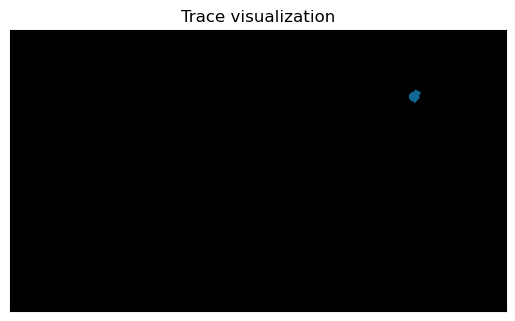

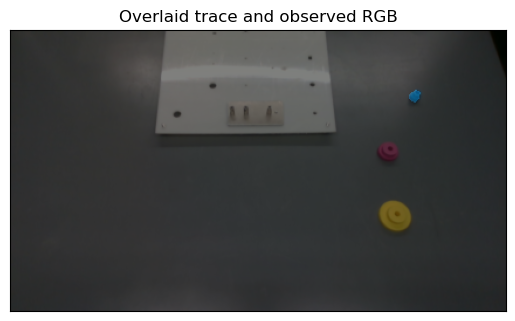

In [11]:
# viz_trace(trace, 1)

def show_trace_and_observed(trace):
    rgbd = renderer.render_rgbd(trace.get_choices()['object_pose_0'].apply(mesh.vertices),
        mesh.faces,
        colors)

    plt.figure()
    plt.imshow(rgbd[...,:3])
    plt.title('Trace visualization')
    plt.xticks([])
    plt.yticks([])
    plt.imsave(f'latent_trace_{frame_name}.png', rgbd[...,:3])

    plt.figure()
    alpha_blend_overlay = (trace.get_choices()['rgbd'][...,:3] + rgbd[...,:3])/2
    plt.imshow(alpha_blend_overlay)
    plt.title('Overlaid trace and observed RGB')
    plt.xticks([])
    plt.yticks([])
    plt.imsave(f'trace_observed_overlay_{frame_name}.png', alpha_blend_overlay)

show_trace_and_observed(trace)

### construct x-y grid to evaluate local discrete posterior approximation

In [12]:
# Gridding on translation only.
# 0.05 order of magnitude grid moves
x_num_points, y_num_points = 25, 25
# x_grid, y_grid = jnp.linspace(-0.1, 0.1, x_num_points), jnp.linspace(-0.1, 0.1, y_num_points)
x_grid, y_grid = jnp.linspace(-0.025, 0.025, x_num_points), jnp.linspace(-0.025, 0.025, y_num_points)
# x_grid, y_grid = jnp.linspace(-0.005, 0.005, x_num_points), jnp.linspace(-0.005, 0.005, y_num_points)


translation_deltas = jax.vmap(lambda p: Pose.from_translation(p))(
            jnp.stack(
                jnp.meshgrid(
                    x_grid,
                    y_grid,
                    jnp.linspace(0, 0, 1),
                ),
                axis=-1,
            ).reshape(-1, 3)
        )

In [13]:
def _enumerate_and_get_scores(trace, addressses, all_deltas):
    addr = addressses.unwrap()[0]
    current_pose = trace.get_choices()[addr]
    scores_list = []
    for i in range(len(all_deltas)):
        test_poses = current_pose @ all_deltas[i]
        scores = b3d.enumerate_choices_get_scores(
            trace, addressses, test_poses
        )
        scores_list.append(scores)
    return jnp.array(scores_list)


enumerate_and_get_scores = jax.jit(
    _enumerate_and_get_scores, static_argnames=["addressses"]
)

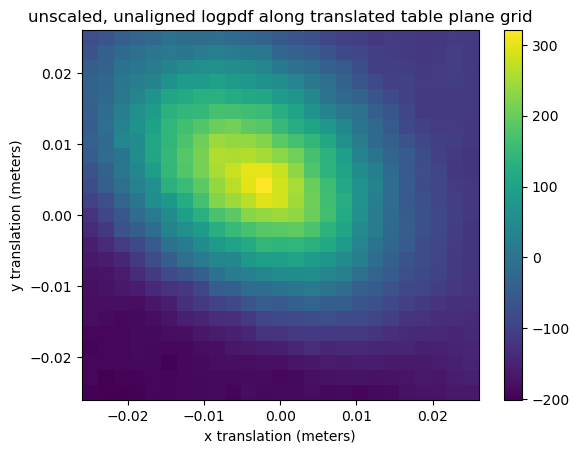

In [14]:
def make_xy_grid_plot(trace, translation_deltas):
    score_grid = enumerate_and_get_scores(trace, Pytree.const(("object_pose_0",)), [translation_deltas])
    grid_scores = score_grid[0].reshape(x_num_points, y_num_points)

    fig, ax = plt.subplots()
    x, y = jnp.meshgrid(x_grid, y_grid)
    c = ax.pcolormesh(x, y, grid_scores, vmin=jnp.min(grid_scores), vmax=jnp.max(grid_scores), shading='auto' )
    ax.set_title('unscaled, unaligned logpdf along translated table plane grid')
    ax.set_xlabel('x translation (meters)')
    ax.set_ylabel('y translation (meters)')

    fig.colorbar(c, ax=ax)
    plt.show()

make_xy_grid_plot(trace, translation_deltas)

In [15]:
def get_rotation_poses(num_rotations):
    rot_pose_generator = jax.vmap(lambda theta: Pose.from_pos_matrix(jnp.zeros(3), rotation_from_axis_angle(jnp.array([0,0,1]), theta)), 0)
    return rot_pose_generator(jnp.linspace(-jnp.pi, jnp.pi,num_rotations))

def make_theta_grid_plot(trace, num_rotations = 250):
    rotation_poses = get_rotation_poses(num_rotations)
    rotation_score_grid = enumerate_and_get_scores(trace, Pytree.const(("object_pose_0",)), [rotation_poses])
    plt.figure(figsize=(10,3))
    plt.plot(jnp.linspace(0, 2*jnp.pi, 250), rotation_score_grid[0], linewidth=3)
    plt.xlabel('grid angle (radians)')
    plt.ylabel('score')
    plt.title(r'grid scores in gear $\theta$')
    plt.show()

# make_theta_grid_plot(trace)

### generate XY and theta grid moves to refine rough gear pose estimate to find true MAP
### posterior approximation will be centered around the MAP estimate

In [16]:
# Generate local pose refinement moves to find the MAP estimate

refinement_x_num_points, refinement_y_num_points = 45, 45
refinement_rotation_deltas = get_rotation_poses(refinement_x_num_points*refinement_y_num_points)
refinement_x_grid = jnp.linspace(-0.025, 0.025, refinement_x_num_points)
refinement_y_grid = jnp.linspace(-0.025, 0.025, refinement_y_num_points)
refinement_translation_deltas = jax.vmap(lambda p: Pose.from_translation(p))(
            jnp.stack(
                jnp.meshgrid(
                    refinement_x_grid,
                    refinement_y_grid,
                    jnp.linspace(0, 0, 1),
                ),
                axis=-1,
            ).reshape(-1, 3)
        )

In [17]:
key = jax.random.PRNGKey(0)
all_deltas = Pose.stack_poses([refinement_translation_deltas, refinement_rotation_deltas])
trace, key = bayes3d.enumerate_and_select_best_move(
            trace, Pytree.const(("object_pose_0",)), key, all_deltas
        )

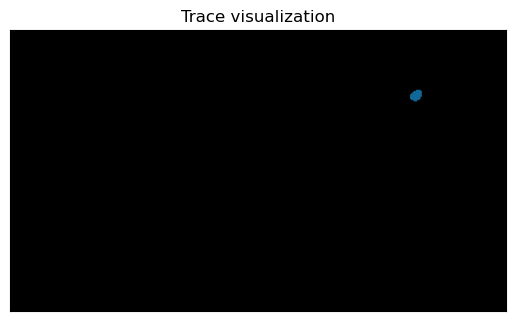

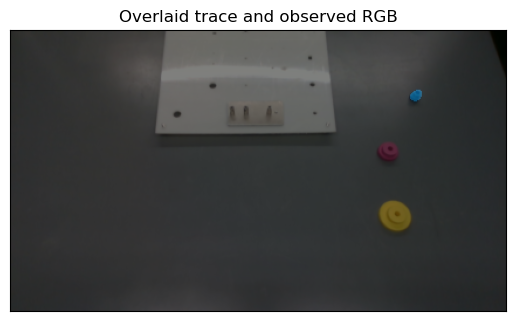

In [18]:
show_trace_and_observed(trace)

In [19]:
# raw posterior is too sharp, this tempering factor is equivalent to p' \propto p^{1/tempering_factor}
tempering_factor = 500

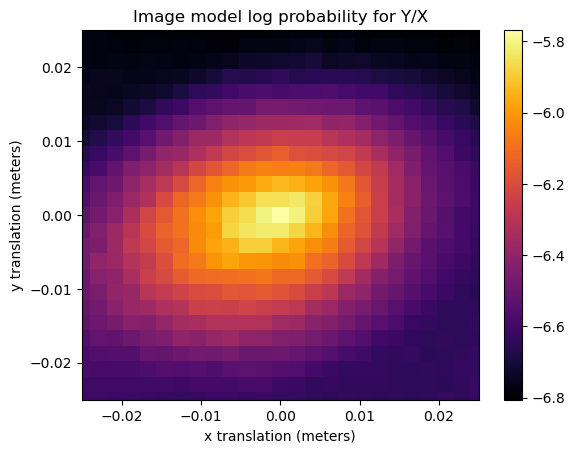

In [20]:
def make_xy_grid_plot(trace, translation_deltas):
    score_grid = enumerate_and_get_scores(trace, Pytree.const(("object_pose_0",)), [translation_deltas])
    score_plot_data = score_grid[0].reshape(y_num_points,x_num_points)

    score_plot_data = score_plot_data/tempering_factor

    # score_plot_data = jnp.exp(score_plot_data - jax.scipy.special.logsumexp(score_plot_data.flatten()))
    score_plot_data = score_plot_data - jax.scipy.special.logsumexp(score_plot_data.flatten())
    
    fig, ax = plt.subplots()
    y, x = jnp.meshgrid(y_grid, x_grid)
    c = ax.pcolormesh(x, y, score_plot_data, vmin=jnp.min(score_plot_data), vmax=jnp.max(score_plot_data))
    #c.set_clim(0,0.1)
    c.set_cmap('inferno')
    ax.set_title('Image model log probability for Y/X')
    ax.set_xlabel('x translation (meters)')
    ax.set_ylabel('y translation (meters)')
    # set the limits of the plot to the limits of the data
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    fig.colorbar(c, ax=ax)
    plt.show()
    fig.savefig(f'xy_posterior_{frame_name}.png', bbox_inches = "tight")

make_xy_grid_plot(trace, translation_deltas)

In [21]:
# make_theta_grid_plot(trace)

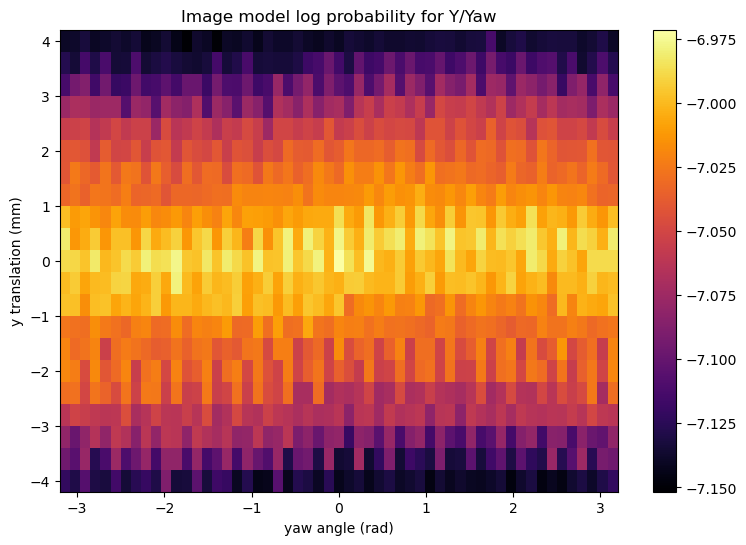

In [22]:
def make_x_yaw_grid_plot(trace, x_grid, num_rotations = 55):
    theta_grid = jnp.linspace(-jnp.pi, jnp.pi,num_rotations)
    rotation_poses = jax.vmap(lambda theta: Pose.from_pos_matrix(jnp.zeros(3), rotation_from_axis_angle(jnp.array([0,0,1]), theta)), 0)(theta_grid)
    translation_deltas = jax.vmap(lambda p: Pose.from_translation(p))(
                jnp.stack(
                    jnp.meshgrid(
                        x_grid,
                        jnp.linspace(0,0,1),
                        jnp.linspace(0,0,1),
                    ),
                    axis=-1,
                ).reshape(-1, 3)
            )
    make_trans_rot_grid_vec = jax.vmap(lambda translation_delta, rotation_poses: translation_delta @ rotation_poses, (0, None))
    
    pose_grid = make_trans_rot_grid_vec(translation_deltas, rotation_poses)
    pose_grid = Pose(pose_grid.pos.reshape(-1,3), pose_grid.quat.reshape(-1,4))
    grid_scores = enumerate_and_get_scores(trace, Pytree.const(("object_pose_0",)), [pose_grid]).reshape(len(x_grid), num_rotations)
    grid_scores = grid_scores/tempering_factor

    # grid_scores = jnp.exp(grid_scores - jax.scipy.special.logsumexp(grid_scores.flatten()))
    grid_scores = grid_scores - jax.scipy.special.logsumexp(grid_scores.flatten())

    
    fig, ax = plt.subplots(figsize=(9,6))
    theta, x = jnp.meshgrid(theta_grid, x_grid * 1000)
    c = ax.pcolormesh(theta, x, grid_scores, vmin=jnp.min(grid_scores), vmax=jnp.max(grid_scores), shading='auto' )
    c.set_cmap('inferno')
    ax.set_title('Image model log probability for Y/Yaw')
    ax.set_ylabel('y translation (mm)')
    ax.set_xlabel('yaw angle (rad)')
    fig.colorbar(c, ax=ax)
    plt.show()
    fig.savefig(f'y_yaw_posterior_{frame_name}.png', bbox_inches = "tight")

num_translations = 21
x_grid = jnp.linspace(-0.004, 0.004, num_translations)
make_x_yaw_grid_plot(trace, x_grid)

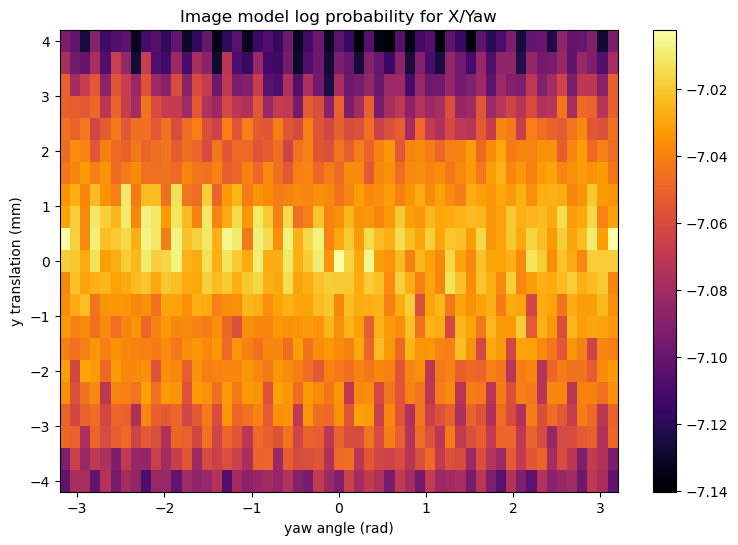

In [23]:
def make_y_yaw_grid_plot(trace, y_grid, num_rotations = 55):
    theta_grid = jnp.linspace(-jnp.pi, jnp.pi,num_rotations)
    rotation_poses = jax.vmap(lambda theta: Pose.from_pos_matrix(jnp.zeros(3), rotation_from_axis_angle(jnp.array([0,0,1]), theta)), 0)(theta_grid)
    translation_deltas = jax.vmap(lambda p: Pose.from_translation(p))(
                jnp.stack(
                    jnp.meshgrid(
                        jnp.linspace(0,0,1),
                        y_grid,
                        jnp.linspace(0,0,1),
                    ),
                    axis=-1,
                ).reshape(-1, 3)
            )
    make_trans_rot_grid_vec = jax.vmap(lambda translation_delta, rotation_poses: translation_delta @ rotation_poses, (0, None))
    
    pose_grid = make_trans_rot_grid_vec(translation_deltas, rotation_poses)
    pose_grid = Pose(pose_grid.pos.reshape(-1,3), pose_grid.quat.reshape(-1,4))
    grid_scores = enumerate_and_get_scores(trace, Pytree.const(("object_pose_0",)), [pose_grid]).reshape(len(y_grid), num_rotations)
    grid_scores = grid_scores/tempering_factor

    # grid_scores = jnp.exp(grid_scores - jax.scipy.special.logsumexp(grid_scores.flatten()))
    grid_scores = grid_scores - jax.scipy.special.logsumexp(grid_scores.flatten())


    
    fig, ax = plt.subplots(figsize=(9,6))
    theta, y = jnp.meshgrid(theta_grid, y_grid * 1000)
    c = ax.pcolormesh(theta, y, grid_scores, vmin=jnp.min(grid_scores), vmax=jnp.max(grid_scores), shading='auto' )
    c.set_cmap('inferno')

    ax.set_title('Image model log probability for X/Yaw')
    ax.set_ylabel('y translation (mm)')
    ax.set_xlabel('yaw angle (rad)')
    fig.colorbar(c, ax=ax)
    # plt.show()
    fig.savefig(f'x_yaw_posterior_{frame_name}.png', bbox_inches = "tight")

num_translations = 21
y_grid = jnp.linspace(-0.004, 0.004, num_translations)
make_y_yaw_grid_plot(trace, y_grid)